In [1]:
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib inline

In [50]:
def find_cutoffs(nu,fnu,fnu_err,nu_nom,buff=5.,N_points=4,low_and_high=True,low_only=False,high_only=False,nu_sanity_low=50.): #buff = 5 GHz default
    '''
    Function to truncate ACTPol and AdvACT passbands to sensible regions
    ---
    For PA1/2/3/4/5/6, determine upper and lower limits where to cut off bandpass
    integrals by finding where the responses
    become consistent with zero [or negative] (within the uncertainties) 
    after being positive for N_points above (below) this cutoff
    for the lower (upper) cutoff (default N_points = 4),
    and then going "buff" GHz beyond that. (default buff = 5 GHz)
    Also require lower cutoff < nu_nom and upper cutoff > nu_nom,
    where nu_nom is the "nominal" band center.
    ---
    Input:
    nu = array of frequencies at which bandpass is measured [GHz]
    fnu = bandpass measurements [dimensionless transmission]
    fnu_err = error bars on bandpass measurements
    nu_nom = bandpass nominal frequency
    buff = buffer to go past final determined cutoffs [GHz]
    N_points = number of consecutive positive measurements used
               to determine cutoffs
    low_and_high = if True, truncate at both low and high ends
    low_only = if True, truncate at low end only
    high_only = if True, truncate at high end only
    nu_sanity_low = sanity cutoff to remove garbage at frequencies nu < nu_sanity_low
    Output:
    truncated arrays of nu, fnu, fnu_err
    '''
    N_nu = len(nu)
    assert(N_nu > 2*N_points)
    for i in range(N_nu-N_points):
        if (nu[i] < nu_nom and nu[i] > nu_sanity_low and fnu[i]-fnu_err[i] <= 0. and all(x > 0. for x in fnu[i+1:i+N_points+1]-fnu_err[i+1:i+N_points+1])):
            lower_cutoff = nu[i]
            break
    for i in range(N_points,N_nu):
        if (nu[i] > nu_nom and fnu[i]-fnu_err[i] <= 0. and all(x > 0. for x in fnu[i-N_points:i]-fnu_err[i-N_points:i])):
            upper_cutoff = nu[i]
            break
    # include buffer on lower and upper cutoffs
    lower_cutoff -= buff
    upper_cutoff += buff
    # don't go beyond the edges of the measurements
    if (lower_cutoff < nu[0]):
        lower_cutoff = nu[0]
    if (upper_cutoff > nu[-1]):
        upper_cutoff = nu[-1]
    print("lower, upper = ",lower_cutoff, upper_cutoff)
    # instead of interpolating, just find elements in nu array nearest to the cutoffs
    idx_low = (np.abs(nu - lower_cutoff)).argmin()
    idx_high = (np.abs(nu - upper_cutoff)).argmin()
    # return the three truncated arrays
    if (low_and_high == True):
        return nu[idx_low:idx_high+1],fnu[idx_low:idx_high+1],fnu_err[idx_low:idx_high+1]
    elif (low_and_high == False and low_only == True):
        return nu[idx_low:],fnu[idx_low:],fnu_err[idx_low:]
    elif (low_and_high == False and high_only == True):
        return nu[:idx_high+1],fnu[:idx_high+1],fnu_err[:idx_high+1]
    else:
        print("No truncation asked for")
        return nu, fnu, fnu_err


In [4]:
# read in ACTPol PA1/2/3 bandpass data
N_ACTPol = 4 #PA1, PA2, PA3_90, PA3_150
files_ACTPol = ['PA1_avg_passband_wErr.txt','PA2_avg_passband_wErr.txt','PA3_avg_passband_90_wErr.txt','PA3_avg_passband_150_wErr.txt']
nu_ACTPol = []
fnu_ACTPol = []
fnu_err_ACTPol = []

for i in range(N_ACTPol):
    nu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,0])
    fnu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,1])
    fnu_err_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,2])

In [5]:
# read in AdvACT PA4/5/6 bandpass data
# as of 4-29-20 via Jeff M. (minor fixes to PA4 and PA6, PA5 unchanged w.r.t. 4-6-20 version)
N_AdvACT = 6 #PA4_150, PA4_220, PA5_90, PA5_150, PA6_90, PA6_150
N_AdvACT_files = 3
files_AdvACT = ['PA4_avg_passband_150_220_wErr_20200429.txt',
                'PA5_avg_passband_90_150_wErr_20200429.txt',
                'PA6_avg_passband_90_150_wErr_20200429.txt']

nu_AdvACT = []
fnu_AdvACT = []
fnu_err_AdvACT = []

for i in range(N_AdvACT_files):
    nu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,0])
    fnu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,1])
    fnu_err_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,2])
    nu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,0])
    fnu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,3])
    fnu_err_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,4])

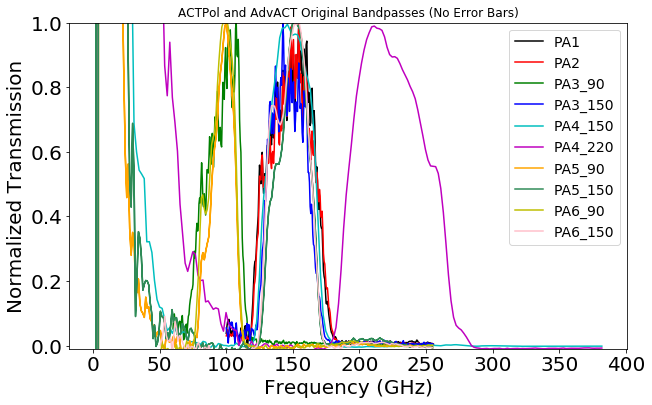

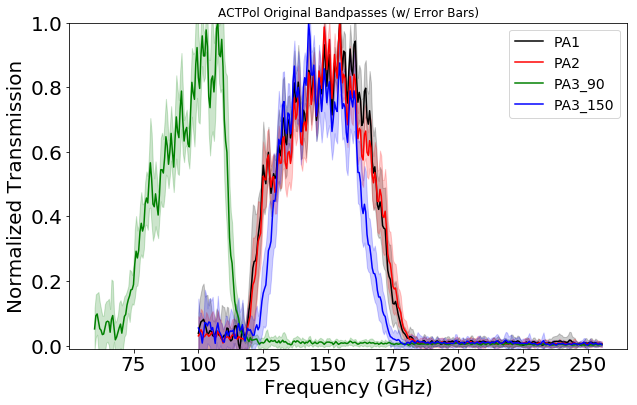

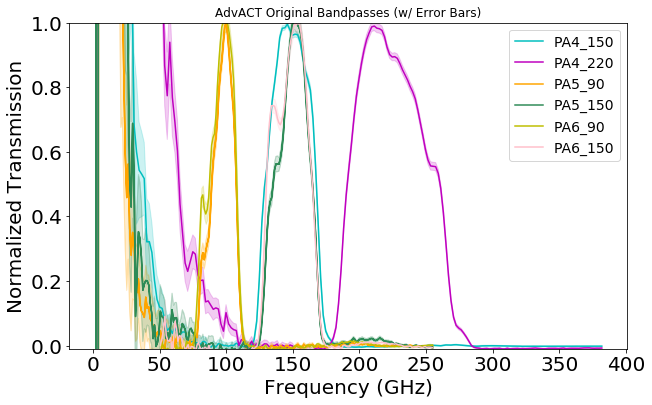

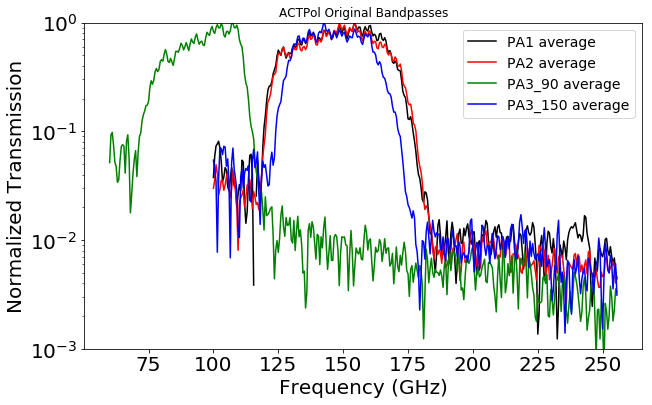

In [9]:
# plots of the original (untruncated) ACTPol and AdvACT bandpasses
# N.B.: from Rahul:
# PA1 = average of 18 individual detector FTSs
# PA2 = average of 75 individual detector FTSs
# PA3_90 = average of 17 individual detector FTSs
# PA3_150 = average of 28 individual detector FTSs

# plot all (no errors for clarity)
colors = ['k','r','g','b','c','m','orange','seagreen','y','pink']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_AdvACT):
    plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
plt.tick_params(labelsize=20)
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1', 'PA2', 'PA3_90', 'PA3_150', 'PA4_150', 'PA4_220', 'PA5_90', 'PA5_150', 'PA6_90', 'PA6_150'], fontsize=14)
plt.title("ACTPol and AdvACT Original Bandpasses (No Error Bars)")
plt.show()

# plot ACTPol only (with errors)
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1', 'PA2', 'PA3_90', 'PA3_150'], fontsize=14)
plt.title("ACTPol Original Bandpasses (w/ Error Bars)")
plt.show()

# plot AdvACT only (with errors)
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
for i in range(N_AdvACT):
    plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA4_150', 'PA4_220', 'PA5_90', 'PA5_150', 'PA6_90', 'PA6_150'], fontsize=14)
plt.title("AdvACT Original Bandpasses (w/ Error Bars)")
plt.show()

# plot all -- log y-axis
colors = ['k','r','g','b']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.semilogy(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
#for i in range(N_ACTPol):
#    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20)
plt.ylim(1.e-3,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.title("ACTPol Original Bandpasses")
plt.show()

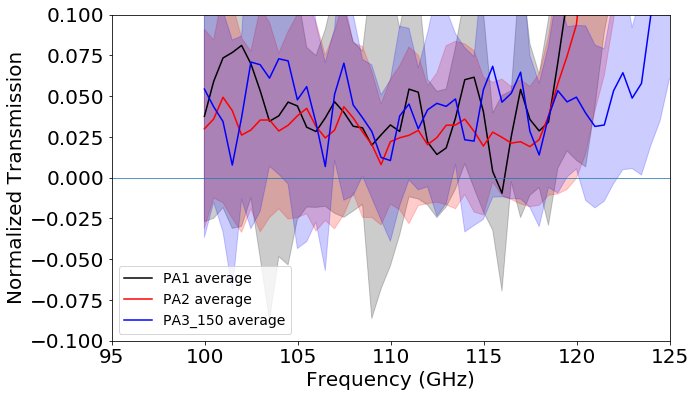

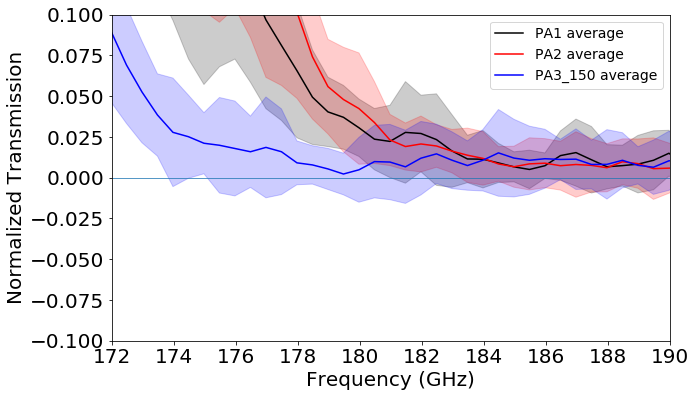

In [6]:
# zoom plots on 150 GHz cutoffs for ACTPol bandpasses
# 150 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    if (i != 2):
        plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    if (i != 2):
        plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_150 average'], fontsize=14)
plt.xlim(95.,125.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

# 150 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    if (i != 2):
        plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(N_ACTPol):
    if (i != 2):
        plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_150 average'], fontsize=14)
plt.xlim(172.,190.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

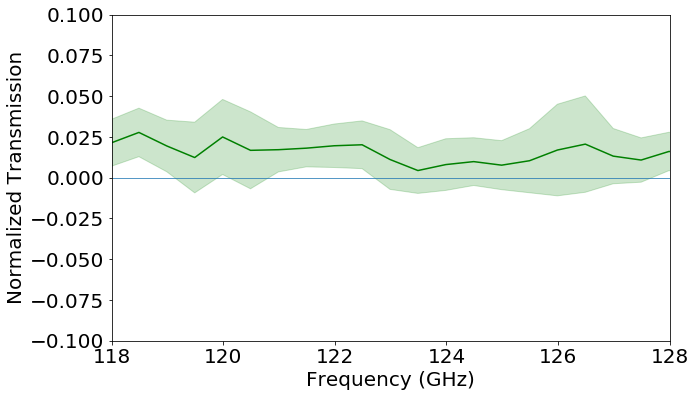

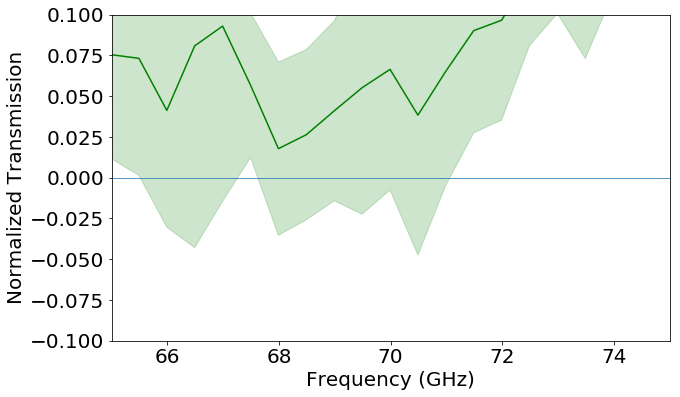

In [7]:
# zoom plots on 90 GHz cutoffs for ACTPol PA3_90 bandpass
# 90 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], color=colors[2])
plt.fill_between(nu_ACTPol[2], fnu_ACTPol[2]-fnu_err_ACTPol[2], fnu_ACTPol[2]+fnu_err_ACTPol[2], color=colors[2], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(118.,128.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()
# 90 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], color=colors[2])
plt.fill_between(nu_ACTPol[2], fnu_ACTPol[2]-fnu_err_ACTPol[2], fnu_ACTPol[2]+fnu_err_ACTPol[2], color=colors[2], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(65.,75.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()


In [8]:
# apply truncation function to ACTPol bandpasses

nu_ACTPol_cut = []
fnu_ACTPol_cut = []
fnu_err_ACTPol_cut = []

nu_nom = np.array([150.,150.,90.,150.])

for i in range(N_ACTPol):
    nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_ACTPol[i], fnu_ACTPol[i], fnu_err_ACTPol[i], nu_nom[i])
    nu_ACTPol_cut.append(nu_cut)
    fnu_ACTPol_cut.append(fnu_cut)
    fnu_err_ACTPol_cut.append(fnu_err_cut)

lower, upper =  113.49 186.48
lower, upper =  114.99 188.48
lower, upper =  65.99 124.49
lower, upper =  116.99 178.98


In [78]:
# save truncated versions
np.savetxt('PA1_avg_passband_wErr_trunc_20200220.txt', np.transpose(np.array([nu_ACTPol_cut[0], fnu_ACTPol_cut[0], fnu_err_ACTPol_cut[0]])))
np.savetxt('PA2_avg_passband_wErr_trunc_20200220.txt', np.transpose(np.array([nu_ACTPol_cut[1], fnu_ACTPol_cut[1], fnu_err_ACTPol_cut[1]])))
np.savetxt('PA3_avg_passband_90_wErr_trunc_20200220.txt', np.transpose(np.array([nu_ACTPol_cut[2], fnu_ACTPol_cut[2], fnu_err_ACTPol_cut[2]])))
np.savetxt('PA3_avg_passband_150_wErr_trunc_20200220.txt', np.transpose(np.array([nu_ACTPol_cut[3], fnu_ACTPol_cut[3], fnu_err_ACTPol_cut[3]])))


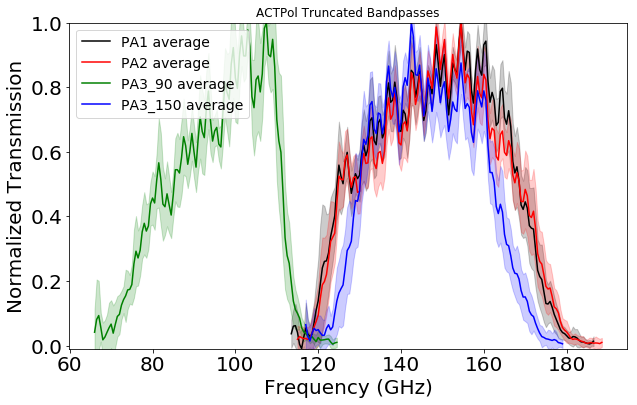

In [9]:
# plot truncated bandpasses
colors = ['k','r','g','b']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol_cut[i], fnu_ACTPol_cut[i], color=colors[i])
for i in range(N_ACTPol):
    plt.fill_between(nu_ACTPol_cut[i], fnu_ACTPol_cut[i]-fnu_err_ACTPol_cut[i], fnu_ACTPol_cut[i]+fnu_err_ACTPol_cut[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.title("ACTPol Truncated Bandpasses")
plt.show()

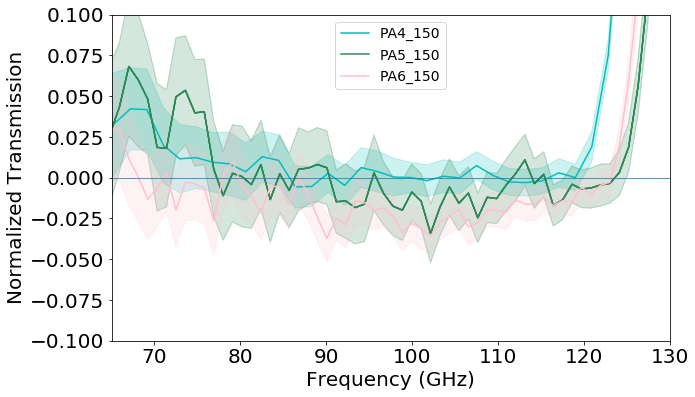

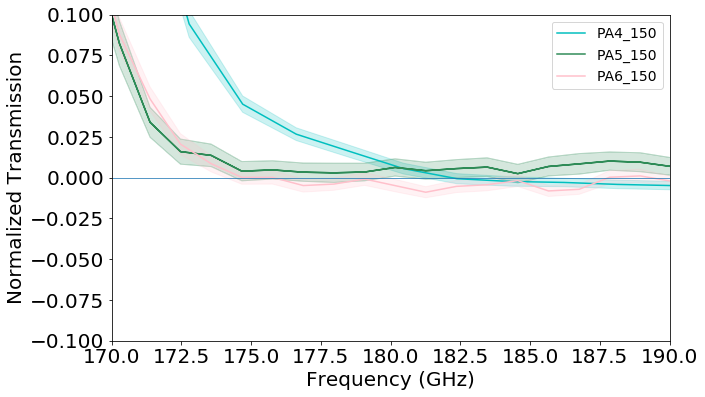

In [56]:
# zoom plots on 150 GHz cutoffs for AdvACT bandpasses
colors = ['k','r','g','b','c','m','orange','seagreen','y','pink']
# 150 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    if (i == 0 or i == 3 or i == 5):
        plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
for i in range(N_AdvACT):
    if (i == 0 or i == 3 or i == 5):
        plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA4_150', 'PA5_150', 'PA6_150'], fontsize=14)
plt.xlim(65.,130.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

# 150 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    if (i == 0 or i == 3 or i == 5):
        plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
for i in range(N_AdvACT):
    if (i == 0 or i == 3 or i == 5):
        plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA4_150', 'PA5_150', 'PA6_150'], fontsize=14)
plt.xlim(170.,190.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

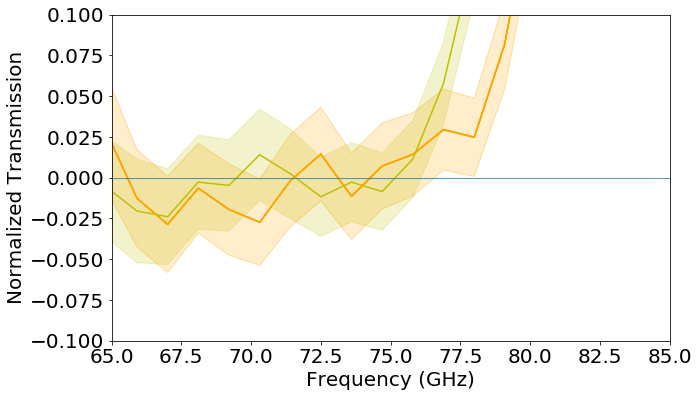

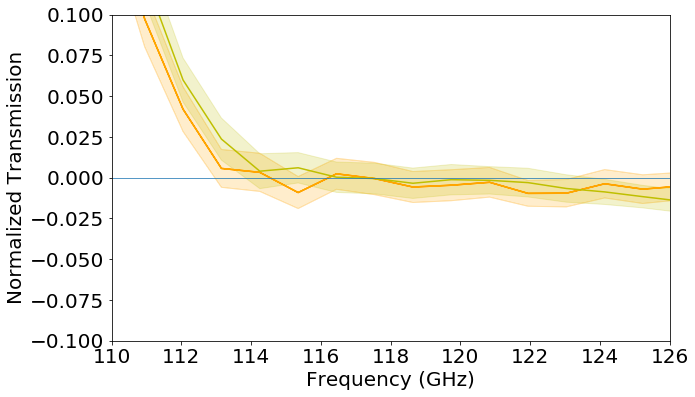

In [48]:
# zoom plots on 90 GHz cutoffs for AdvACT PA5_90 and PA6_90 bandpass
# 90 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    if (i == 2 or i == 4):
        plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
for i in range(N_AdvACT):
    if (i == 2 or i == 4):
        plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(65.,85.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

# 90 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    if (i == 2 or i == 4):
        plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i+4])
for i in range(N_AdvACT):
    if (i == 2 or i == 4):
        plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(110.,126.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()



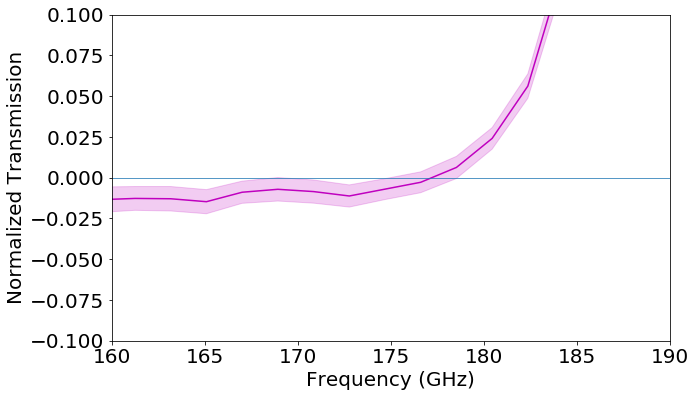

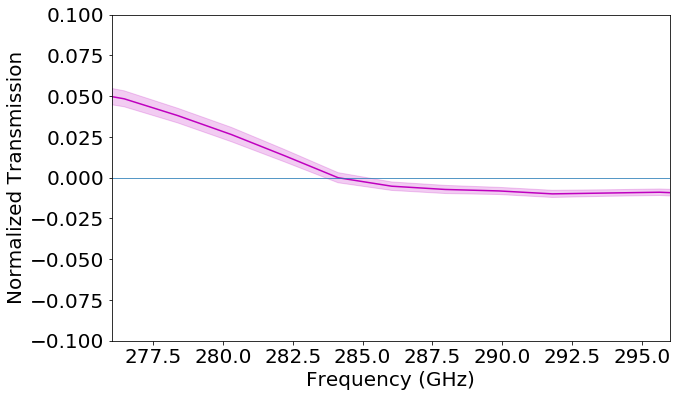

In [49]:
# zoom plots on 220 GHz cutoffs for ACTPol PA4_220 bandpass
# 220 GHz zoom: lower cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_AdvACT[1], fnu_AdvACT[1], color=colors[1+4])
plt.fill_between(nu_AdvACT[1], fnu_AdvACT[1]-fnu_err_AdvACT[1], fnu_AdvACT[1]+fnu_err_AdvACT[1], color=colors[1+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(160.,190.)
#plt.xlim(0.,10.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

# 220 GHz zoom: upper cutoff
plt.figure(figsize=(10,6))
plt.plot(nu_AdvACT[1], fnu_AdvACT[1], color=colors[1+4])
plt.fill_between(nu_AdvACT[1], fnu_AdvACT[1]-fnu_err_AdvACT[1], fnu_AdvACT[1]+fnu_err_AdvACT[1], color=colors[1+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.xlim(276.,296.)
plt.ylim(-0.1,0.1)
plt.axhline(y=0.,lw=0.75)
plt.show()

In [58]:
# apply truncation function to AdvACT bandpasses

nu_AdvACT_cut = []
fnu_AdvACT_cut = []
fnu_err_AdvACT_cut = []

nu_nom = np.array([150.,220.,90.,150.,90.,150.])

for i in range(N_AdvACT):
    if (i == 0 or i == 1 or i == 3 or i == 5):
        nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_AdvACT[i], fnu_AdvACT[i], fnu_err_AdvACT[i], nu_nom[i], buff=5.,N_points=4,low_and_high=True,low_only=False,high_only=False,nu_sanity_low=80.)
    if (i == 2 or i == 4):
        nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_AdvACT[i], fnu_AdvACT[i], fnu_err_AdvACT[i], nu_nom[i], buff=5.,N_points=4,low_and_high=True,low_only=False,high_only=False,nu_sanity_low=60.)
    nu_AdvACT_cut.append(nu_cut)
    fnu_AdvACT_cut.append(fnu_cut)
    fnu_err_AdvACT_cut.append(fnu_err_cut)

lower, upper =  114.02 187.38
lower, upper =  173.54 289.12
lower, upper =  70.8 118.15
lower, upper =  119.14 179.67
lower, upper =  70.8 119.25
lower, upper =  118.04 179.67


In [59]:
# save truncated versions
np.savetxt('PA4_avg_passband_f150_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[0], fnu_AdvACT_cut[0], fnu_err_AdvACT_cut[0]])))
np.savetxt('PA4_avg_passband_f220_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[1], fnu_AdvACT_cut[1], fnu_err_AdvACT_cut[1]])))
np.savetxt('PA5_avg_passband_f090_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[2], fnu_AdvACT_cut[2], fnu_err_AdvACT_cut[2]])))
np.savetxt('PA5_avg_passband_f150_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[3], fnu_AdvACT_cut[3], fnu_err_AdvACT_cut[3]])))
np.savetxt('PA6_avg_passband_f090_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[4], fnu_AdvACT_cut[4], fnu_err_AdvACT_cut[4]])))
np.savetxt('PA6_avg_passband_f150_wErr_trunc_20200505.txt', np.transpose(np.array([nu_AdvACT_cut[5], fnu_AdvACT_cut[5], fnu_err_AdvACT_cut[5]])))


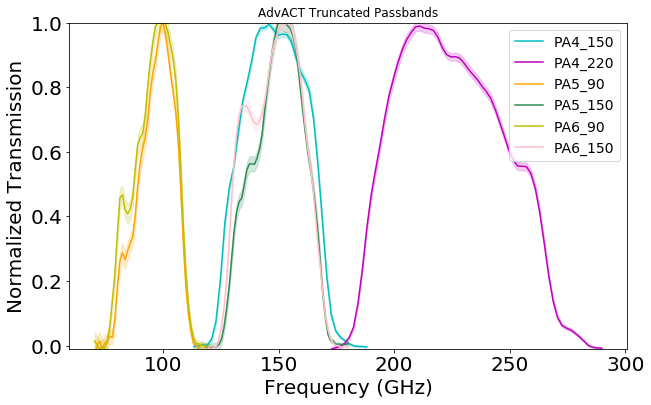

In [62]:
# plot truncated bandpasses
colors = ['k','r','g','b','c','m','orange','seagreen','y','pink']
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    plt.plot(nu_AdvACT_cut[i], fnu_AdvACT_cut[i], color=colors[i+4])
for i in range(N_AdvACT):
    plt.fill_between(nu_AdvACT_cut[i], fnu_AdvACT_cut[i]-fnu_err_AdvACT_cut[i], fnu_AdvACT_cut[i]+fnu_err_AdvACT_cut[i], color=colors[i+4], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA4_150', 'PA4_220', 'PA5_90', 'PA5_150', 'PA6_90', 'PA6_150'], fontsize=14)
plt.title("AdvACT Truncated Passbands")
plt.show()

In [10]:
def find_cutoffs_noerrs(nu,fnu,nu_nom,buff=5.,N_points=7): #buff = 5 GHz default
    '''
    FUNCTION TO TRUNCATE ACT MBAC BANDPASSES TO SENSIBLE REGIONS
    ---
    For MBAC AR1/2/3, determine upper and lower limits where to cut off bandpass
    integrals by finding where the responses
    become negative (NO ERROR BARS PROVIDED)
    after being positive for N_points above (below) this cutoff
    for the lower (upper) cutoff (default N_points = 7),
    and then going "buff" GHz beyond that. (default buff = 5 GHz)
    Also require lower cutoff < nu_nom and upper cutoff > nu_nom,
    where nu_nom is the "nominal" band center.
    ---
    Input:
    nu = array of frequencies at which bandpass is measured [GHz]
    fnu = bandpass measurements [dimensionless transmission]
    nu_nom = bandpass nominal frequency
    buff = buffer to go past final determined cutoffs [GHz]
    N_points = number of consecutive positive measurements used
               to determine cutoffs
    Output:
    truncated arrays of nu, fnu, fnu_err
    '''
    assert(nu_nom > 0.)
    N_nu = len(nu)
    assert(N_nu > 2*N_points)
    for i in range(N_nu-N_points):
        if (nu[i] < nu_nom and fnu[i] <= 0. and all(x > 0. for x in fnu[i+1:i+N_points+1])):
            lower_cutoff = nu[i]
            break
    for i in range(N_points,N_nu):
        if (nu[i] > nu_nom and fnu[i] <= 0. and all(x > 0. for x in fnu[i-N_points:i])):
            upper_cutoff = nu[i]
            break
    # include buffer on lower and upper cutoffs
    lower_cutoff -= buff
    upper_cutoff += buff
    # don't go beyond the edges of the measurements
    if (lower_cutoff < nu[0]):
        lower_cutoff = nu[0]
    if (upper_cutoff > nu[-1]):
        upper_cutoff = nu[-1]
    print("lower, upper = ",lower_cutoff, upper_cutoff)
    # instead of interpolating, just find elements in nu array nearest to the cutoffs
    idx_low = (np.abs(nu - lower_cutoff)).argmin()
    idx_high = (np.abs(nu - upper_cutoff)).argmin()
    # return the two truncated arrays
    return nu[idx_low:idx_high+1],fnu[idx_low:idx_high+1]

In [11]:
# read in ACT AR1/2/3 bandpass data
N_ACT = 3 #AR1,AR2,AR3 (148,218,277)
files_ACT = ['MBAC_AR1_148GHz.txt','MBAC_AR2_218GHz.txt','MBAC_AR3_277GHz.txt']
nu_ACT = []
fnu_ACT = []

for i in range(N_ACT):
    nu_ACT.append(np.loadtxt(files_ACT[i])[:,0])
    fnu_ACT.append(np.loadtxt(files_ACT[i])[:,1])

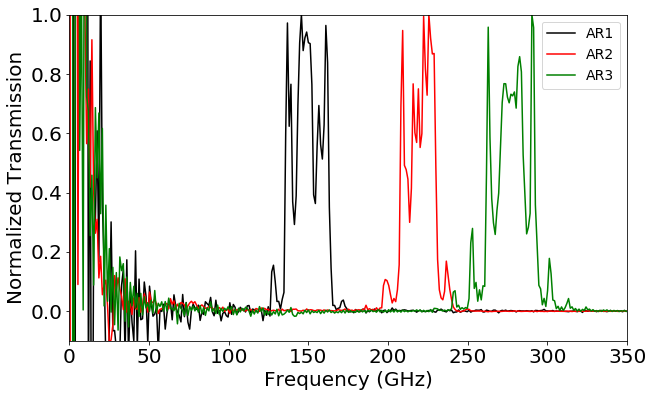

In [12]:
# plot of original (untruncated) ACT bandpasses
plt.figure(figsize=(10,6))
plt.xlim(0.,350.)
plt.ylim(-0.1,1.)
for i in range(N_ACT):
    plt.plot(nu_ACT[i], fnu_ACT[i], color=colors[i])
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['AR1', 'AR2', 'AR3'], fontsize=14)
plt.show()

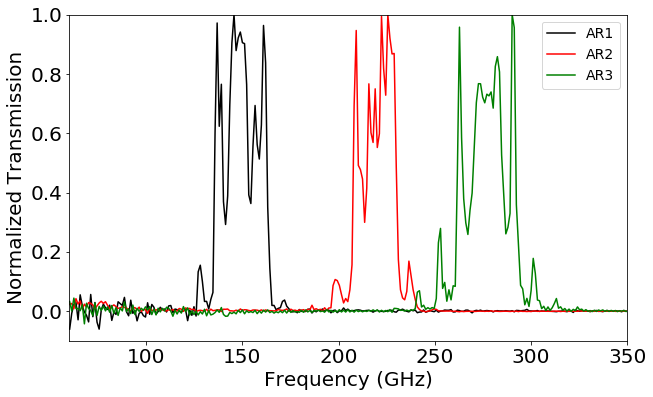

In [13]:
# everything below ~60 GHz is clearly garbage, so throw it out
nu_cut = 60.

nu_ACT_new = []
fnu_ACT_new = []

for i in range(N_ACT):
    keep = np.where(nu_ACT[i] > nu_cut)
    nu_ACT_new.append(nu_ACT[i][keep])
    fnu_ACT_new.append(fnu_ACT[i][keep])

# plot of sanity-cut ACT bandpasses
plt.figure(figsize=(10,6))
plt.xlim(nu_cut,350.)
plt.ylim(-0.1,1.)
for i in range(N_ACT):
    plt.plot(nu_ACT_new[i], fnu_ACT_new[i], color=colors[i])
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['AR1', 'AR2', 'AR3'], fontsize=14)
plt.show()

In [14]:
# apply truncation function to ACT MBAC bandpasses

nu_ACT_cut = []
fnu_ACT_cut = []

nu_nom_ACT = np.array([148.,218.,277.])

for i in range(N_ACT):
    nu_cut, fnu_cut = find_cutoffs_noerrs(nu_ACT_new[i], fnu_ACT_new[i], nu_nom_ACT[i])
    nu_ACT_cut.append(nu_cut)
    fnu_ACT_cut.append(fnu_cut)

lower, upper =  120.93974 180.22051
lower, upper =  95.75179 250.30872
lower, upper =  222.78666 325.87256


In [91]:
# save truncated versions
np.savetxt('MBAC_AR1_148GHz_trunc_20200220.txt', np.transpose(np.array([nu_ACT_cut[0], fnu_ACT_cut[0]])))
np.savetxt('MBAC_AR2_218GHz_trunc_20200220.txt', np.transpose(np.array([nu_ACT_cut[1], fnu_ACT_cut[1]])))
np.savetxt('MBAC_AR3_277GHz_trunc_20200220.txt', np.transpose(np.array([nu_ACT_cut[2], fnu_ACT_cut[2]])))


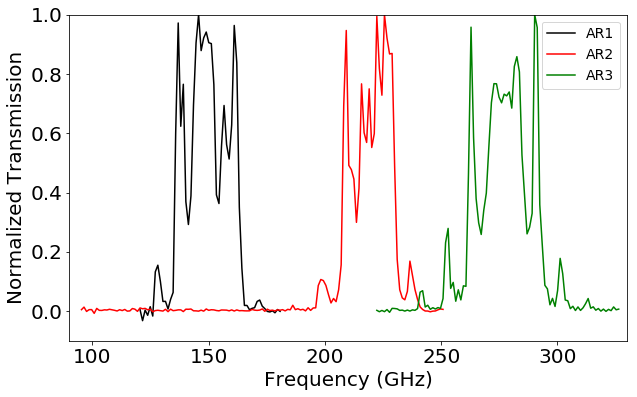

In [15]:
# plot truncated bandpasses
plt.figure(figsize=(10,6))
plt.xlim(90.,330.)
plt.ylim(-0.1,1.)
for i in range(N_ACT):
    plt.plot(nu_ACT_cut[i], fnu_ACT_cut[i], color=colors[i])
plt.tick_params(labelsize=20) 
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['AR1', 'AR2', 'AR3'], fontsize=14)
plt.show()

In [16]:
# read in ACTPol PA4/5/6 bandpass data
#N_AdvACT = 6 #PA4_150, PA4_230, PA5_90, PA5_150, PA6_90, PA6_150
N_AdvACT = 2 #currently only have PA6_90, PA6_150
#files_AdvACT = ['FILLIN.txt','PA2_avg_passband_wErr.txt','PA3_avg_passband_90_wErr.txt','PA3_avg_passband_150_wErr.txt']
files_AdvACT = ['PA6_preliminary_Jeff_email_12-16-19.txt','PA6_preliminary_Jeff_email_12-16-19.txt']
nu_AdvACT = []
fnu_AdvACT = []
fnu_err_AdvACT = []

for i in range(N_AdvACT):
    nu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,0])
    if (i == 0): #90 GHz
        fnu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,1])
        fnu_err_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,2])
    if (i == 1): #150 GHz
        fnu_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,3])
        fnu_err_AdvACT.append(np.loadtxt(files_AdvACT[i])[:,4])

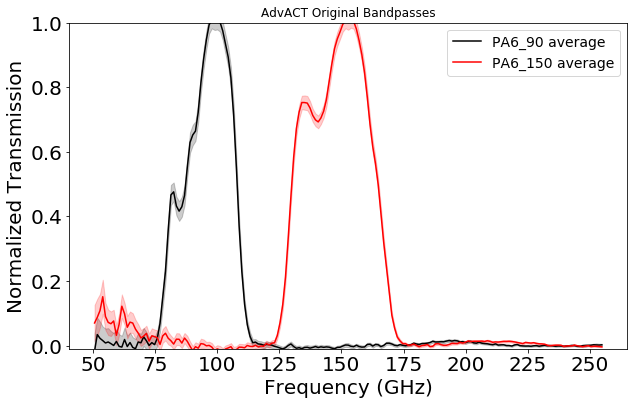

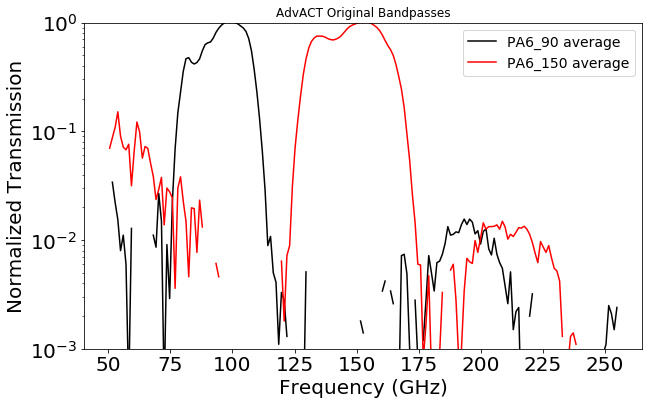

In [17]:
# plots of the original (untruncated) AdvACT bandpasses

# plot all
colors = ['k','r','g','b','c','m']
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    plt.plot(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i])
for i in range(N_AdvACT):
    plt.fill_between(nu_AdvACT[i], fnu_AdvACT[i]-fnu_err_AdvACT[i], fnu_AdvACT[i]+fnu_err_AdvACT[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
#plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.legend(['PA6_90 average', 'PA6_150 average'], fontsize=14)
plt.title("AdvACT Original Bandpasses")
plt.show()

# plot all -- log y-axis
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    plt.semilogy(nu_AdvACT[i], fnu_AdvACT[i], color=colors[i])
#for i in range(N_ACTPol):
#    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20)
plt.ylim(1.e-3,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
#plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.legend(['PA6_90 average', 'PA6_150 average'], fontsize=14)
plt.title("AdvACT Original Bandpasses")
plt.show()

In [18]:
# truncate -- note that doing this directly removes the blue leak
# as expected, since the bandpass goes to zero before the leak comes in
# apply truncation function to AdvACT bandpasses

nu_AdvACT_cut = []
fnu_AdvACT_cut = []
fnu_err_AdvACT_cut = []

# define a second set of bandpasses that include the blue leak
nu_AdvACT_BL = []
fnu_AdvACT_BL = []
fnu_err_AdvACT_BL = []

#nu_nom = np.array([150.,230.,90.,150.,90.,150.])
nu_nom = np.array([90.,150.])

for i in range(N_AdvACT):
    nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_AdvACT[i], fnu_AdvACT[i], fnu_err_AdvACT[i], nu_nom[i])
    nu_AdvACT_cut.append(nu_cut)
    fnu_AdvACT_cut.append(fnu_cut)
    fnu_err_AdvACT_cut.append(fnu_err_cut)
    # keep BL
    nu_cut, fnu_cut, fnu_err_cut = find_cutoffs(nu_AdvACT[i], fnu_AdvACT[i], fnu_err_AdvACT[i], nu_nom[i], low_and_high=False, low_only=True)
    nu_AdvACT_BL.append(nu_cut)
    fnu_AdvACT_BL.append(fnu_cut)
    fnu_err_AdvACT_BL.append(fnu_err_cut)

# Jeff email 2-20-2020: chop out blue leak stuff above 225 GHz
# 225 looks like a good cutoff for PA6_90
# 235 looks like a good cutoff for PA6_150
nu_BL_cut_PA6_90 = 225.
nu_BL_cut_PA6_150 = 235.

# UPDATE THIS WHEN PA4 AND PA5 ARE INCLUDED!
keep_PA6_90 = np.where(nu_AdvACT_BL[0] < nu_BL_cut_PA6_90)
keep_PA6_150 = np.where(nu_AdvACT_BL[1] < nu_BL_cut_PA6_150)
nu_AdvACT_BL[0] = nu_AdvACT_BL[0][keep_PA6_90]
nu_AdvACT_BL[1] = nu_AdvACT_BL[1][keep_PA6_150]
fnu_AdvACT_BL[0] = fnu_AdvACT_BL[0][keep_PA6_90]
fnu_AdvACT_BL[1] = fnu_AdvACT_BL[1][keep_PA6_150]
fnu_err_AdvACT_BL[0] = fnu_err_AdvACT_BL[0][keep_PA6_90]
fnu_err_AdvACT_BL[1] = fnu_err_AdvACT_BL[1][keep_PA6_150]


lower, upper =  70.8 119.25
lower, upper =  70.8 119.25
lower, upper =  118.04 181.87
lower, upper =  118.04 181.87


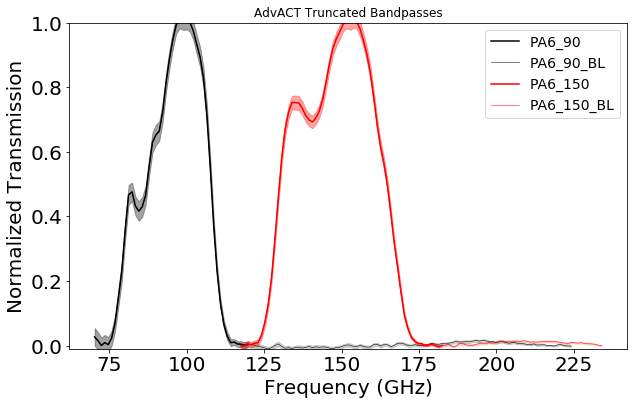

In [19]:
# plot truncated bandpasses
plt.figure(figsize=(10,6))
for i in range(N_AdvACT):
    plt.plot(nu_AdvACT_cut[i], fnu_AdvACT_cut[i], color=colors[i])
    plt.plot(nu_AdvACT_BL[i], fnu_AdvACT_BL[i], color=colors[i], lw=0.5)
for i in range(N_AdvACT):
    plt.fill_between(nu_AdvACT_cut[i], fnu_AdvACT_cut[i]-fnu_err_AdvACT_cut[i], fnu_AdvACT_cut[i]+fnu_err_AdvACT_cut[i], color=colors[i], alpha=0.2)
    plt.fill_between(nu_AdvACT_BL[i], fnu_AdvACT_BL[i]-fnu_err_AdvACT_BL[i], fnu_AdvACT_BL[i]+fnu_err_AdvACT_BL[i], color=colors[i], alpha=0.2, lw=0.5)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
#plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.legend(['PA6_90', 'PA6_90_BL', 'PA6_150', 'PA6_150_BL'], fontsize=14)
plt.title("AdvACT Truncated Bandpasses")
plt.show()

In [114]:
# save truncated versions and BL versions
# trunc
np.savetxt('PA6_90GHz_preliminary_Jeff_email_12-16-19_trunc_20200220.txt', np.transpose(np.array([nu_AdvACT_cut[0], fnu_AdvACT_cut[0], fnu_err_AdvACT_cut[0]])))
np.savetxt('PA6_150GHz_preliminary_Jeff_email_12-16-19_trunc_20200220.txt', np.transpose(np.array([nu_AdvACT_cut[1], fnu_AdvACT_cut[1], fnu_err_AdvACT_cut[1]])))
# BL
np.savetxt('PA6_90GHz_preliminary_Jeff_email_12-16-19_trunc_BL_20200220.txt', np.transpose(np.array([nu_AdvACT_BL[0], fnu_AdvACT_BL[0], fnu_err_AdvACT_BL[0]])))
np.savetxt('PA6_150GHz_preliminary_Jeff_email_12-16-19_trunc_BL_20200220.txt', np.transpose(np.array([nu_AdvACT_BL[1], fnu_AdvACT_BL[1], fnu_err_AdvACT_BL[1]])))


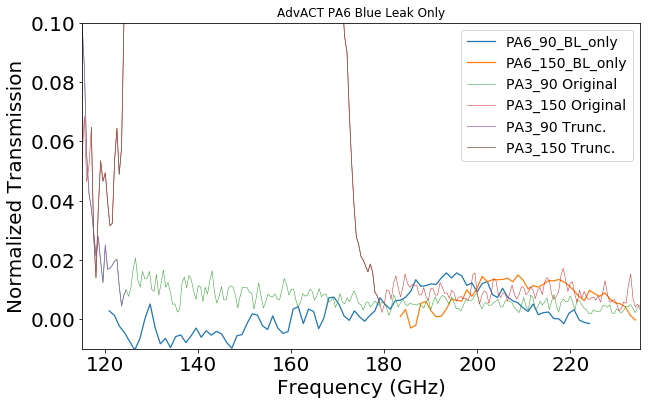

In [20]:
# excise the blue leak from PA5 or PA6 so it can be added to PA3
# get the BL by taking difference of the trunc and BL arrays and then removing the zero elements
# 90
nu_low_BL_cut_PA6_90 = nu_AdvACT_cut[0][-1]
nu_low_BL_cut_PA6_150 = nu_AdvACT_cut[1][-1]

# UPDATE THIS IF NEEDED
keep_PA6_90 = np.where(nu_AdvACT_BL[0] > nu_low_BL_cut_PA6_90)
keep_PA6_150 = np.where(nu_AdvACT_BL[1] > nu_low_BL_cut_PA6_150)
nu_PA6_90_BL_only = nu_AdvACT_BL[0][keep_PA6_90]
nu_PA6_150_BL_only = nu_AdvACT_BL[1][keep_PA6_150]
fnu_PA6_90_BL_only = fnu_AdvACT_BL[0][keep_PA6_90]
fnu_PA6_150_BL_only = fnu_AdvACT_BL[1][keep_PA6_150]

# plot to check
# also plot the original PA3 bandpasses to compare
plt.figure(figsize=(10,6))
plt.plot(nu_PA6_90_BL_only, fnu_PA6_90_BL_only, lw=1.25)
plt.plot(nu_PA6_150_BL_only, fnu_PA6_150_BL_only, lw=1.25)
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], lw=0.5)
plt.plot(nu_ACTPol[3], fnu_ACTPol[3], lw=0.5)
plt.plot(nu_ACTPol_cut[2], fnu_ACTPol_cut[2], lw=0.75)
plt.plot(nu_ACTPol_cut[3], fnu_ACTPol_cut[3], lw=0.75)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,0.1)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
#plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.legend(['PA6_90_BL_only', 'PA6_150_BL_only', 'PA3_90 Original', 'PA3_150 Original', 'PA3_90 Trunc.', 'PA3_150 Trunc.'], fontsize=14)
plt.title("AdvACT PA6 Blue Leak Only")
plt.xlim(115.,235.)
plt.show()


65.99 0.041284
116.99 0.064709


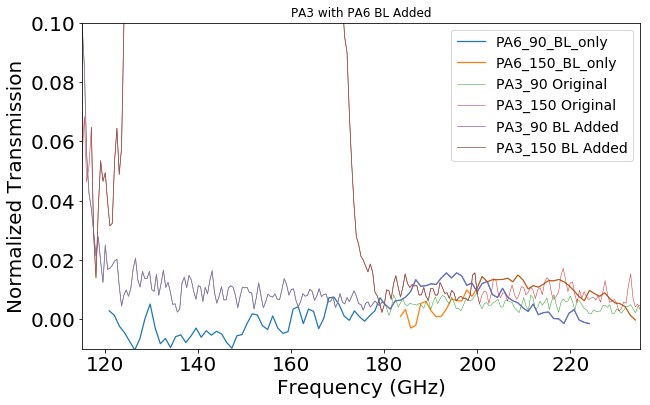

In [49]:
# append the blue leak onto PA3 90 and 150 GHz, be careful to preserve smoothness
# start with the original PA3 data
nu_PA3_90 = np.copy(nu_ACTPol[2])
fnu_PA3_90 = np.copy(fnu_ACTPol[2])
nu_PA3_150 = np.copy(nu_ACTPol[3])
fnu_PA3_150 = np.copy(fnu_ACTPol[3])

# manually find where the PA3 90 GHz data crosses the blue leak
# result: basically right on 180 GHz
#  this is element index 240 in nu_PA3_90
#  and element index 54 in nu_PA6_90_BL_only
#print(nu_PA3_90[240])
#print(fnu_PA3_90[240])
#print(nu_PA6_90_BL_only[54], fnu_PA6_90_BL_only[54])
# delete everything from element 240 onward in PA3_90 and then
#   replace with the PA6_90 blue leak
nu_PA3_90 = nu_PA3_90[:241]
fnu_PA3_90 = fnu_PA3_90[:241]
nu_PA3_90_wBL = np.append(nu_PA3_90,nu_PA6_90_BL_only[54:])
fnu_PA3_90_wBL = np.append(fnu_PA3_90,fnu_PA6_90_BL_only[54:])
# then perform a low-end truncation -- from above, we know the low-end cutoff is 65.98 GHz
keep = np.where(nu_PA3_90_wBL > 65.98)
nu_PA3_90_wBL = nu_PA3_90_wBL[keep]
fnu_PA3_90_wBL = fnu_PA3_90_wBL[keep]
print(nu_PA3_90_wBL[0],fnu_PA3_90_wBL[0])

# manually find where the PA3 150 GHz data crosses the blue leak
# result: basically right on 200 GHz
#  this is element index 200 in nu_PA3_150
#  and element index 15 in nu_PA6_150_BL_only
#print(nu_PA3_150[200],fnu_PA3_150[200])
#print(nu_PA6_150_BL_only[15], fnu_PA6_150_BL_only[15])
# delete everything from element 200 onward in PA3_150 and then
#   replace with the PA6_150 blue leak
nu_PA3_150 = nu_PA3_150[:201]
fnu_PA3_150 = fnu_PA3_150[:201]
nu_PA3_150_wBL = np.append(nu_PA3_150,nu_PA6_150_BL_only[15:])
fnu_PA3_150_wBL = np.append(fnu_PA3_150,fnu_PA6_150_BL_only[15:])
# then perform a low-end truncation -- from above, we know the low-end cutoff is 116.98 GHz
keep = np.where(nu_PA3_150_wBL > 116.98)
nu_PA3_150_wBL = nu_PA3_150_wBL[keep]
fnu_PA3_150_wBL = fnu_PA3_150_wBL[keep]
print(nu_PA3_150_wBL[0],fnu_PA3_150_wBL[0])

# plot
plt.figure(figsize=(10,6))
plt.plot(nu_PA6_90_BL_only, fnu_PA6_90_BL_only, lw=1.25)
plt.plot(nu_PA6_150_BL_only, fnu_PA6_150_BL_only, lw=1.25)
plt.plot(nu_ACTPol[2], fnu_ACTPol[2], lw=0.5)
plt.plot(nu_ACTPol[3], fnu_ACTPol[3], lw=0.5)
plt.plot(nu_PA3_90_wBL, fnu_PA3_90_wBL, lw=0.75)
plt.plot(nu_PA3_150_wBL, fnu_PA3_150_wBL, lw=0.75)
plt.tick_params(labelsize=20)
plt.ylim(-0.01,0.1)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
#plt.legend(['PA1 average', 'PA2 average', 'PA3_90 average', 'PA3_150 average'], fontsize=14)
plt.legend(['PA6_90_BL_only', 'PA6_150_BL_only', 'PA3_90 Original', 'PA3_150 Original', 'PA3_90 BL Added', 'PA3_150 BL Added'], fontsize=14)
plt.title("PA3 with PA6 BL Added")
plt.xlim(115.,235.)
plt.show()

In [50]:
# save PA3 90 and 150 GHz versions with blue leak best-guess model included
np.savetxt('PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt', np.transpose(np.array([nu_PA3_90_wBL, fnu_PA3_90_wBL])))
np.savetxt('PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt', np.transpose(np.array([nu_PA3_150_wBL, fnu_PA3_150_wBL])))
